In [2]:
%matplotlib inline


import pandas as pd
import numpy as np
import regex
import os, sys
import matplotlib.pyplot as plt

# USER INPUTS

In [3]:



"""Experiment name to prepend output files"""
EXPERIMENT = "ratio_graphing-2"

"""Directory path to input data 
    (filtered; output from '1-read_fastq_id_features)
"""
FILTERED_FILEPATH = "../output/filtered-sample-nh.csv"
# FILTERED_FILEPATH = "../output/filtered-ratios.csv"
# FILTERED_FILEPATH = "../output/filtered-18014.csv"
# FILTERED_FILEPATH = '../../../2016-09-19-validation_graphs_redoes/data/filtered-ratios.csv'
"""Directory path to save output"""
OUTPUT_DIRECTORY = "../output"

"""Minimum number of reads as a baseline. Used to simplify data processing."""
MIN_READS = 100


# PRESETS AND SCRIPT

In [4]:
"""
# NEED TO FIGURE HOW TO RELOAD DEPENDENT FUNCTIONS
UPON VALUE CHANGES
Column names correspoinding to eponymous variables"""

SAMPLE = 'idx'
QTAG = 'qtag'
BARCODE = 'barcode'
READS = 'readsPF'
MCOUNTS = 'mcountsPF'
PERCENT_MCOUNTS = 'percent_%s'%MCOUNTS
GROUPBY = ['idx']# for older versions/ formats

In [5]:
def check_inputs():
    
    # modules
    assert pd
    assert np
    assert regex
    assert os
    assert sys
    
    # user experiment inputs 
    assert EXPERIMENT
    assert FILTERED_FILEPATH
    assert OUTPUT_DIRECTORY
    assert MIN_READS
    
    # user columns
    assert SAMPLE
    assert QTAG
    assert BARCODE
    assert READS
    assert MCOUNTS
    assert PERCENT_MCOUNTS
    assert GROUPBY
    

In [6]:
# 2016-11-04 updated to include filter delete bool feature
"""calculate_percent_molecs
    calculates percent of mcounts of barcodes.
    df: pd.DataFrame() 
    mcounts: str, optional, col to calculate percents, default MCOUNTS
    percent_mcounts: str, col to assign values to, default PERCENT_MCOUNTS
    filters: list, np.array, dict, columns and bool values to filter values
    
    Returns: 
        df with updated percent_mcounts values
"""
def calculate_percent_molecs(df, mcounts=MCOUNTS, percent_mcounts=PERCENT_MCOUNTS, filters=[]):
    """Updates percent molec counters for sample"""
    
    df.loc[:,percent_mcounts] = 0.
    if len(filters) > 0:
        var, val = filters[0]
        cond = (df[var]==val)
        i = 1
        while i < len(filters):
            var, val = filters[i]
            cond = cond & (df[var]==val)
            i+=1
    else:
        cond = ()
    total = df.loc[cond, mcounts].values.sum() / 100.
    df.loc[cond,percent_mcounts] = df.apply(lambda x: x[mcounts]/total, axis=1)
    df.sort_values(by=[percent_mcounts,mcounts, BARCODE], 
                   ascending=[0,0,1], inplace=True)
    return df

In [7]:
def load_data(filtered_file, sample=SAMPLE, qtag=QTAG, 
              barcode=BARCODE, mcounts=MCOUNTS, reads=READS):
    """Loads filtered lib-ID-barcode data csv to dict of samples"""
    columns = [sample, qtag, barcode, mcounts, reads]
    # loads excel file (all tabs)
    
    csv = pd.read_csv(filtered_file)
    # filter out null barcodes just in case (if custom user input)
    csv = csv.loc[(csv[qtag]!='None') & (csv[barcode]!='None')]
    csv = csv[columns]
    csv[sample] = csv[sample].apply(lambda x: str(x))
    # get percent molecs per sample, store as output dict entry 
    groups = csv.groupby(sample)
    data = []
    for i, group in csv.groupby(sample):
        data.append((i,calculate_percent_molecs(group)))
    return data


In [8]:
def check_data(d, sample=SAMPLE, mcounts=MCOUNTS, reads=READS):
    """Check data for proper format, input values, and 
    converts into list-like object if necessary

    d(list, np.array ,dict, or pd.DataFrame): input data
    
    Returns: data set as a list-like object, wherein
        each item is a pair containing sample name (str) and 
        sample data (pd.DataFrame), in that order.
    """
    data_arr = []
    # wrangle data to list of list-like pairs, as "[idx, df]"
    if type(d) in [np.array, list] :
        data_arr = d
    elif type(d) == dict:
        data_arr = d.items()
    elif type(d) == pd.DataFrame :
        data_arr = [(s,df) for s,df in d.groupby(sample)]
    else:
        print "Input data is not in correct format. Please provide \
        list-like, dict, or pd.DataFrame object."
    
    # check input has correct values
    try:
        for a in data_arr:
            assert len(a) == 2, "incorrect item length"
            s, df = a
            assert type(s) == str, 'sample name is not string type'
            assert type(df) == pd.DataFrame, "incorrect value type: must be pd.DataFrame"
            assert sample in df.columns, "%s not in dataframe"%sample
            assert mcounts in df.columns, "%s not in dataframe"%mcounts
            assert reads in df.columns, "%s not in dataframe"%reads
    # if no 
    except IndexError as e:
        print "Item number of values is not 2.\n"
        print "IndexError. ",e.message
        print a
    except ValueError as e:
        print "Sample name could not be converted to float: %s\n"% type(item[i])
        print "ValueError. ",e.message
        print a
    except AssertionError as e:
        print "Assertion failed:"
        print e.message
        print a
    
    return data_arr

In [9]:
"""OLD THRESHOLD"""

def threshold(group, reps_remaining, thresh_mcounts,threshold_log,
             mcounts=MCOUNTS):
    """Thresholds barcodes of a given sample

        group(pd.DataFrame): df containing library-ID-barcodes, 
            mcountsPF and percent_mcountsPF
        reps_remaining(int): reps remaining from max number 
            input from user 
        thresh_val(float or int): initial threshold value (percent_mcountPF)
            provided from previous recursion or user input
        thresh_i(int): initial position of threshold value in 
            percent_mcountsPF list, ranging 0,len(group)

        Returns: 
            None, if thresholding fails;
            passed(pd.DataFrame), if thresholding successful; or
            self, otherwise, with updated threshold values and 
                group df.
    """
#     print "\nSTART", len(group)
    # max out reps
    if reps_remaining <= 0:
        print 'Maxed out reps. Skipping sample.'
    # no barcodes passed threshold 
    elif len(group) == 0:
        print "No barcodes passed threshold. Skipping sample."
    else:
        # calculate new threshold 
        group.sort_values(by=mcounts, ascending=False, inplace=True)
        mcount_vals = group.loc[(group['passed']==True)|(group['is_padding']==True)][mcounts].values
#         mcount_vals = thresh_group[mcounts].values
#         mcount_vals = mcount_vals + [1] if thresh_mcounts < 0 or len(thresh_group) <= 3 else mcount_vals
#         print "G", group
#         print "THRG", thresh_group
#         print"MCV",  mcount_vals
#         print "else", reps_remaining, len(group), len(mcount_vals)
        new_thresh_mcounts = calculate_threshold(mcount_vals)
#         print "after", reps_remaining, len(group), thresh_mcounts, new_thresh_mcounts
        
        threshold_log.append(len(group.loc[group[mcounts]>=new_thresh_mcounts]))
        print '\n',reps_remaining, len(group)
        print 'old', thresh_mcounts
        print group.loc[(group[mcounts]>=thresh_mcounts)&(group[mcounts]>1)][['qtag','barcode','mcountsPF','passed','is_padding']]
        print 'new', new_thresh_mcounts
        print group.loc[group[mcounts]>=new_thresh_mcounts][['qtag','barcode','mcountsPF','passed','is_padding']]
#         print len(thresh_group.loc[thresh_group[mcounts]>new_thresh_mcounts])
        
#         print len(group), len(thresh_group)
        # if reached steady state
        if new_thresh_mcounts == thresh_mcounts:
#             re_thresholded_v = calculate_threshold(group.loc[group['passed']==True][mcounts].values)
#             print thresh_mcounts, re_thresholded_v
#             passed = eliminate_oneoffs(group, re_thresholded_v, pad=False)
#             passed = eliminate_oneoffs(group, new_thresh_mcounts, pad=False)
#             print len(group.loc[group['passed']==True]), len(passed.loc[passed['passed']==True])
            group['passed'] = group.apply(lambda x:
                            True if x['passed']==True and
                            x['is_padding']==False and
                            x[mcounts]>=new_thresh_mcounts else False, axis=1)
            passed_val = group.loc[group['passed']==True,mcounts].min()
            threshold_log.append(len(group.loc[group[mcounts]>=passed_val]))

            print 'final'
            print group.loc[group['passed']==True][['qtag','barcode','mcountsPF','passed','is_padding']]
#             group.loc[(group['passed']==True)
#                               &(group['is_padding']==False)
#                               &(group[mcounts]>=thresh_mcounts)]
            
            group = calculate_percent_molecs(group,filters=[['passed',True],['is_padding',False]])
#             passed = calculate_percent_molecs(group, 
#                         filters=[['passed',True],['is_padding',False]])
            group.reset_index(inplace=True,drop=True)
            print "FINAL", len(group.loc[group['passed']==True])
            sys.stdout.write('Thresholded.\n')
            return group, threshold_log
        # recursively clean and re-threshold
        else:
#             print reps_remaining
#             print len(group), thresh_mcounts, new_thresh_mcounts
            # clean up group by eliminating one-offs
            cleaned = eliminate_oneoffs(group,new_thresh_mcounts)
            cleaned.reset_index(inplace=True,drop=True)
#             print reps_remaining, len(cleaned.loc[cleaned['passed']==True])
            # recurse with cleaned df and new threshold values
            return threshold(cleaned, reps_remaining-1, new_thresh_mcounts, threshold_log,
                             mcounts=mcounts)
        
    # if thresholding failed, return None
    sys.stdout.write('Skipped.\n')
    return pd.DataFrame()

In [10]:
# STEP 2: CALCULATE THRESHOLD VALUE via. CONCAVITY


def calculate_threshold(y, by='passed', mcounts=MCOUNTS):
    """Calculates threshold of series with modified concavity approach

        y(np.array or list): list or list-like object of 
            values as floats or ints

        Returns index of inflection point in array, 
            i.e. threshold position.
    """
    def rolling_window(arr):
        """Constructs list of overlapping subarray ranges of size 2"""
        shape = arr.shape[:-1] + (arr.shape[-1]-1, 2)
        strides = arr.strides + (arr.strides[-1],)
        windows = np.lib.stride_tricks.as_strided(arr, 
                              shape=shape, strides=strides)
        return windows
    def first_d_gen(windows):
        """Generates first derivative of windows as relative difference"""
        for w in windows:
            # amended 2016-10-12: normalize by y midpoint instead of second point to 
            # better represent the count magnitude of segment
            yield float(w[1]-w[0])/(w[0]+w[1])*2
    def second_d_gen(windows):
        """Generates second derivative of windows"""
        for w in windows:
            yield w[1]-w[0]       
            
    if type(y) in [np.ndarray, list]:
        x_temp = np.array([])
        y_temp = np.array(y)
    else:
        y = pd.DataFrame(y)
        sortby, cond = [mcounts], (y[mcounts]>0)
        if by in y.columns:
            sortby, cond = ['passed']+sortby, cond&(y['passed']==True) 
        passed = y.loc[cond].sort_values(by=sortby,ascending=False)[mcounts]
        x_temp = passed.index.values
        y_temp = passed.values
    
    
    y_temp = np.sort(np.array(y_temp))[::-1]
    # left and right padding to cover all array vals in derivations
    suffix = [] if len(y_temp) > 2 else [1]
#     suffix=[]
#     suffix = [] if len(y_temp) > 1 else [y_temp[0]]
#     suffix = [y_temp[len(y_temp)-1]/(y_temp[0]+y_temp[1])*2]
#     if len(y_temp) < 2:
#         suffix = [y_temp[len(y_temp)-1]/2]
#     else:
#         suffix =  [y_temp[len(y_temp)-1] -
#                    (y_temp[len(y_temp)-2]-y_temp[len(y_temp)-1])]
    
    yarray = np.concatenate([ [y_temp[0]], y_temp, suffix])
    # calculates first derivative
    first_windows = rolling_window(yarray)
    first_derivs = np.fromiter(first_d_gen(first_windows), np.float
                               , count=len(first_windows))
    # calculates second derivative
    second_windows = rolling_window(first_derivs)
    second_derivs = np.fromiter(second_d_gen(second_windows), np.float
                                , count=len(second_windows))
    # gets index or position value of inflection point (curves down ), adjust by adding 1
    # for second deriv
    thresh_i = min(np.argmin(second_derivs)+1, len(y_temp)-1)
    thresh_v = y_temp[thresh_i]
    
#     print "min", np.min(second_derivs), np.argmin(second_derivs)
#     print 'max', np.max(second_derivs), np.argmax(second_derivs)
    return thresh_v

In [11]:
def eliminate_oneoffs(g, thresh_val, pad=True,
                      qtag=QTAG, barcode=BARCODE, passed='passed',
                      barcode_error = 'barcode_error',
                      qtag_error = 'qtag_error',
                      mcounts=MCOUNTS):
    """Eliminate barcodes that are one position off from a more-abundant barcode
        group(pd.DataFrame): df containing qtag, barcode, and percent_mcounts columns
        thresh_val(float): threshold value to select high abundant barcodes
            to iterate through as 'major' ones
        pad(bool): if True, adds a right pad so last non-eliminated value 
            can be analyzed in by the threshold() function. Default True.
        qtag, barcode, percent_mcounts, mcounts (str): column names for the corresponding
            argument. Defaults are global vars QTAG, BARCODE, PERCENT_MCOUNTS, MCOUNTS.

        Returns: table of barcodes that passed elimination
        
        For regex package info, see https://pypi.python.org/pypi/regex/
    """
    g.sort_values(by=mcounts, ascending=False, inplace=True)
    g.loc[g[mcounts] < thresh_val, 'passed'] = False
    g.loc[:,'is_padding'] = False
    failed = []
#     print "elim", len(g), thresh_val, len(g.loc[g['passed']==True]), len( g.loc[(g['passed']==True)&(g[mcounts])>=thresh_val])
#     majors = filter_g.loc[(filter_g[mcounts])>thresh_val]
    i = 0
    # add capability to check other parameters, i.e. qtag
#     for maj_i, maj_r in g.loc[(g['passed']==True)&(g[mcounts])>=thresh_val].iterrows():
    for maj_i, maj_r in g.loc[g['passed']==True].iterrows():
        # if it has not yet been tested
        if g.loc[maj_i,'passed'] == True:
#             print 'passed maj', maj_r[mcounts]
#             minors = filter_g.loc[filter_g[mcounts]<maj_r[mcounts]]

            minors = g.loc[(g['passed']==True)&(g[mcounts]<maj_r[mcounts])]

            # for each 'minor' barcode aka. with fewer molecs, test if one-off from major
            for min_i, min_r in minors.iterrows():
                query = regex.search("(%s){s<=1}"% maj_r[barcode], min_r[barcode])
                if query:
                    g.loc[min_i,'passed'] = False
                    g.loc[min_i,'barcode_error'] += 1 if sum(query.fuzzy_counts)>0 else 0
                    g.loc[min_i,'qtag_error'] += 1 if min_r[qtag]!=maj_r[qtag] else 0
#                     if min_r[mcounts] < thresh_val:
                    failed.append([min_i, min_r[mcounts]])
                                          
            i+=1
                    
#     # if requested, adds a right pad  
#     # line added 2016-10-12: combine two conditions: ensure that 
#     # no null rows get added if all barcodes are accepted
#     g.loc[:,'passed'] = g.apply(lambda x: False if g.index in failed else x['passed'], axis=1)
#     print len(g), len(g.loc[g['passed']==False]), len(failed)
#     print "THR VAL",thresh_val
#     print g
#     print g['passed']==False
    if len(failed) > 0:
        failed.sort(key=lambda x: x[1])
        failed = failed[::-1]
    
#     if pad==True and len(failed) > 0:
    if pad==True and len(g) != len(g.loc[g['passed']==False]):
        pad_i = [f[0] for f in failed[:1]]
        pad_i = g.loc[(g['passed']==False),mcounts][:1].index.values
#         print "PADI", pad_i
        for pi in pad_i:
            g.loc[pi,'is_padding'] = True
#         print "PADI ADJ"
#         print g
    return g
            

In [12]:
def run_threshold(d, sample=SAMPLE, qtag=QTAG, barcode=BARCODE, 
                  mcounts=MCOUNTS, reads=READS, percent_mcounts=PERCENT_MCOUNTS,
                  min_reads=MIN_READS, min_mcount=50):
    """Run threshold algorithm for each sample in dataset

        d(np.array, list, dict, or pd.DataFrame): dataset for all samples
        sample, qtag, barcode, mcounts, reads, percent_mcounts(str): columns in df for 
            corresponding vals. Defaults are global vars SAMPLE, QTAG, BARCODE, MCOUNTS, 
            READS, PERCENT_MCOUNTS.
        min_reads(int): minimum number of reads for a library-ID-barcode as an 
            absolute baseline (that which any barcode below is highly likely to be 
            false.) Default is global var MIN_READS.
        min_mcount(int): minimum number of molecs for library-ID-barcode as an
            absolute baseline. Default is 50.

        Note: min_reads and min_mcount are applied to increase performance.

        Returns: 
            pd.DataFrame, if successful, of 'true' (passed) library-ID-barcodes 
                for all samples
            None, if no samples had passing library-ID-barcodes.
    """
    passed = []
    all_threshold_logs = {}
    counter = 1
    # checks and formats data (d) to list-like obj of pairs
    data_arr = check_data(d, sample=sample, mcounts=mcounts, reads=reads)
    # run for each (sample, df) in dataset 
    for s, group in data_arr:
        sys.stdout.write("\n-------------\nSample %d of %d (%s): "%(counter,len(data_arr),s))
        # select valid data meeting absolute baseline 
        g = group.loc[(group[qtag] != 'None') & (group[barcode] != 'None') 
                          & (group[mcounts] > min_mcount)]
#                           & (group[reads] > min_reads)]
        if len(g)>0:
            g.loc[:,'passed'] = True
            g.loc[:,'qtag_error'] = False
            g.loc[:,'barcode_error'] = False
            g.loc[:,'is_padding'] = False
            result, tlogs = threshold(g, 20, -1, [])
            passed.append(result)
            all_threshold_logs[s] = tlogs
        sys.stdout.flush()
        counter += 1


    # if we do have data (i.e. some barcodes that passed in the samples)
    if len(passed) > 0:
        # concat all df together
        passeddf = pd.concat(passed)
        passeddf.sort_values(by=[sample,percent_mcounts]
                             ,ascending=[True, False]
                             ,inplace=True)
        passeddf.reset_index(inplace=True,drop=True)
        return passeddf, all_threshold_logs
    else:
        print "No samples were successfully thresholded."
    return 

### SCRIPT TO SAVE DATA TO CSVs

In [13]:
def save_data(filtered,passed, output_directory=OUTPUT_DIRECTORY, experiment=EXPERIMENT):
    
    # Save passed dataframe
    passed.to_csv('%s/threshold-%s-passed.csv'%(output_directory,experiment), index=False)
    # count and save results
    counts = count_sample_barcodes(passed)
    counts.to_csv('%s/threshold-%s-counts.csv'%(output_directory,experiment), index=False)
    # merge passed and filtered data and save
    fc_temp = pd.concat([d[1] for d in filtered])
    filtered_concat = apply_passed_data(fc_temp, passed)
    filtered_concat.to_csv('%s/threshold-%s-merged.csv'%(output_directory,experiment), index=False)

In [14]:
def count_sample_barcodes(df, groupby=SAMPLE, barcode=BARCODE, sample=SAMPLE, qtag=QTAG
                      , percent_mcounts=PERCENT_MCOUNTS):
    """Counts passed barcodes per sample and saves as csv
    
        df(pd.DataFrame): input dataframe containing passed 
            barcodes of all samples
        groupby(str or list-like): columns to group samples by
    """
    agg = df.groupby(groupby).agg(len)
    counts = agg[agg.columns[0]]
    counts.name = 'count'
    counts = pd.DataFrame(counts)
    counts.reset_index(inplace=True)
    return counts



In [15]:
def apply_passed_data(filtered, passeddf, sample=SAMPLE, qtag=QTAG
                      , barcode=BARCODE, percent_mcounts=PERCENT_MCOUNTS):
    """Cross reference passed barcodes with raw filtered data
        filtered(pd.DataFrame): raw filtered data as dataframe for all samples
        passed(pd.DataFrame): data passed threshold (output of run_threshold)
        sample,qtag,barcode,percent_mcounts(str): names corresponding to df columns.
            Defaults are SAMPLE,QTAG,BARCODE,PERCENT_MCOUNTS.

        Returns:
            filtered(pd.DataFrame) updated with 'passed_threshold' and 
            percent_mcounts columns
    """
    def cross_ref_passed(row):
        key = (row[sample],row[qtag],row[barcode])
        if key in passed_indexed.index:
            row.loc[:,percent_mcounts+'_thresholded'] = passed_indexed.loc[key,percent_mcounts]
            row.loc[:,'passed_threshold'] = True
        return row

    passed_indexed = passeddf.set_index([sample,qtag,barcode])
    filtered.rename(columns={percent_mcounts:percent_mcounts+'_filtered'})
    filtered.loc[:,'passed_threshold'] = False
    filtered.loc[:,percent_mcounts+'_thresholded'] = 0
    filtered = filtered.apply(cross_ref_passed, axis=1)
    return filtered



# EXECUTE SCRIPT BELOW

In [16]:
if __name__=='__main__':
    # Check all inputs exist and are valid
    check_inputs()
    # Runs data loading in script
    filtered = load_data(FILTERED_FILEPATH)
    # Run thresholding of all samples in dataset
    passeddf, all_threshold_logs = run_threshold(filtered)
#     save_data(filtered, passeddf, output_directory=OUTPUT_DIRECTORY, experiment=EXPERIMENT)

C:\Users\vwl698\Anaconda2\lib\site-packages\pandas\core\indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\vwl698\Anaconda2\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\vwl698\Anaconda2\lib\site-packages\ipykernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde


-------------
Sample 1 of 16 (NH001): 

C:\Users\vwl698\Anaconda2\lib\site-packages\ipykernel\__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\vwl698\Anaconda2\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



20 8
old -1
     qtag  barcode  mcountsPF passed is_padding
1826  q26  CGGGTGC      79525   True      False
1827  q26  CGGGCGC        296   True      False
1828  q26  CGGGTAC        277   True      False
1829  q26  CGGATGC        256   True      False
1830  q26  CGAGTGC         84   True      False
1831  q26  TGGGTGC         79   True      False
1832  q26  CGGGTGT         64   True      False
1833  q24  CGGGTGC         51   True      False
new 296
     qtag  barcode  mcountsPF passed is_padding
1826  q26  CGGGTGC      79525   True      False
1827  q26  CGGGCGC        296   True      False

19 8
old 296
  qtag  barcode  mcountsPF passed is_padding
0  q26  CGGGTGC      79525   True      False
1  q26  CGGGCGC        296  False       True
new 296
  qtag  barcode  mcountsPF passed is_padding
0  q26  CGGGTGC      79525   True      False
1  q26  CGGGCGC        296  False       True
final


C:\Users\vwl698\Anaconda2\lib\site-packages\ipykernel\__main__.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


  qtag  barcode  mcountsPF passed is_padding
0  q26  CGGGTGC      79525   True      False
FINAL 1
Thresholded.

-------------
Sample 2 of 16 (NH002): 
20 5
old -1
     qtag  barcode  mcountsPF passed is_padding
1713  q26  CATCTTC      45730   True      False
1714  q26  CGGGTGC      39901   True      False
1715  q26  CGGGCGC        134   True      False
1716  q26  CGGGTAC         95   True      False
1717  q26  CGGATGC         84   True      False
new 134
     qtag  barcode  mcountsPF passed is_padding
1713  q26  CATCTTC      45730   True      False
1714  q26  CGGGTGC      39901   True      False
1715  q26  CGGGCGC        134   True      False

19 5
old 134
  qtag  barcode  mcountsPF passed is_padding
0  q26  CATCTTC      45730   True      False
1  q26  CGGGTGC      39901   True      False
2  q26  CGGGCGC        134  False       True
new 134
  qtag  barcode  mcountsPF passed is_padding
0  q26  CATCTTC      45730   True      False
1  q26  CGGGTGC      39901   True      False
2  q26  CGGG

In [17]:
fconcat = pd.concat([d[1] for d in filtered if d[0][:2]!="VL" ])
merged = fconcat.merge(passeddf, 
              on=['idx','qtag','barcode','mcountsPF','readsPF'], 
                       how='outer')
merged.drop(['percent_mcountsPF_x','is_padding'],axis=1, inplace=True)
merged.rename(columns={'percent_mcountsPF_y':"percent_mcountsPF"}, inplace=True)
merged = merged.fillna(value={'passed':False,'qtag_error':False,'barcode_error':False,
                    'percent_mcountsPF':0.})

In [ ]:
passed

In [26]:
passeddf.loc[passeddf['passed']==True].groupby('idx').apply(len)

idx
NH001      1
NH002      2
NH003      3
NH004      4
NH005      5
NH006      7
NH007      8
NH008      9
NH009     10
NH010     11
NH025      2
NH075     71
NH096     88
NH120      2
NH125    108
NH144      2
dtype: int64

In [19]:
merged.loc[(merged['passed']==True)|(merged.mcountsPF > 300)]

,idx,qtag,barcode,mcountsPF,readsPF,percent_mcountsPF,passed,qtag_error,barcode_error
0,NH001,q26,CGGGTGC,79525,84870,100.000000,True,False,False
86,NH002,q26,CATCTTC,45730,44673,53.403557,True,False,False
87,NH002,q26,CGGGTGC,39901,37299,46.596443,True,False,False
199,NH003,q26,ATGACGG,27992,25573,36.465010,True,False,False
200,NH003,q26,CGGGTGC,27205,24212,35.439789,True,False,False
201,NH003,q26,CATCTTC,21567,19547,28.095201,True,False,False
318,NH004,q26,CGGGTGC,28607,25851,32.334889,True,False,False
319,NH004,q26,CATCTTC,24426,22240,27.609047,True,False,False
320,NH004,q26,ATGACGG,22324,20063,25.233127,True,False,False
321,NH004,q26,AAACGTG,13114,11370,14.822936,True,False,False


In [20]:
passeddf.to_csv("%s/passed-%s.csv"%(OUTPUT_DIRECTORY,EXPERIMENT))

In [21]:
all_threshold_logs

{'NH001': [2, 2, 1],
 'NH002': [3, 3, 2],
 'NH003': [4, 4, 3],
 'NH004': [5, 5, 4],
 'NH005': [6, 6, 5],
 'NH006': [8, 8, 7],
 'NH007': [9, 9, 8],
 'NH008': [10, 10, 9],
 'NH009': [11, 11, 10],
 'NH010': [12, 12, 11],
 'NH025': [2, 2, 2],
 'NH075': [76, 76, 76],
 'NH096': [98, 98, 98],
 'NH120': [2, 2, 2],
 'NH125': [125, 120, 120, 120],
 'NH144': [2, 2, 2]}

In [22]:
passed_counts = passeddf.loc[passeddf['passed']==True].groupby('idx').apply(len)

In [23]:
for idx, group in passeddf.groupby('idx'):
    passed_g = group.loc[group['passed']==True,'mcountsPF']
    thresh_val = passed_g.values[-1]
    over_thresh = len(group.loc[group['mcountsPF']>=thresh_val])
    print idx, thresh_val, len(group.loc[group['passed']==True,'mcountsPF']), over_thresh

NH001 79525 1 1
NH002 39901 2 2
NH003 21567 3 3
NH004 13114 4 4
NH005 8961 5 5
NH006 6136 7 7
NH007 5868 8 8
NH008 3063 9 9
NH009 5150 10 10
NH010 3195 11 11
NH025 7393 2 2
NH075 68 71 76
NH096 60 88 98
NH120 2262 2 2
NH125 217 108 120
NH144 2831 2 2


## GRAPHING

In [24]:
itypes = {
    (True,False,False):'passed', #passed
    (False,True,False):'qtag mismatch', #qtag error
    (False,False,True):'barcode oneoff', #barcode error
    (False,False,False):'other error' #not one-off
}

for itype in itypes:
    keys = ['passed','qtag_error','barcode_error']
    ca = [(merged[k]==v) for k,v in zip(keys,itype)]
    cond = ca[0]&ca[1]&ca[2]
    merged.loc[(cond),'itype'] = itypes[itype]
    
ctypes = {
    'passed':'#11BF08',
    'barcode oneoff': '#DE092B',
    'qtag mismatch':'#EBA709',
    'other error':'#2A52D5'
}
itype_order = [
    'passed',
    'other error',
    'barcode oneoff',
    'qtag mismatch'
]

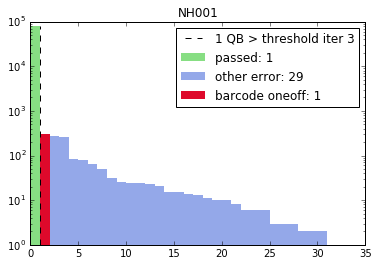

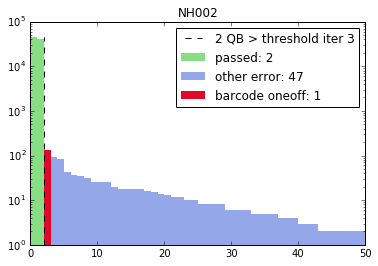

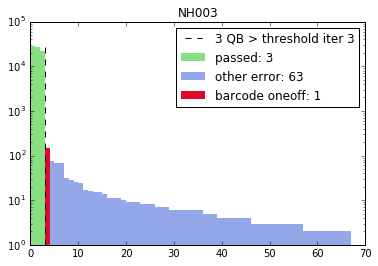

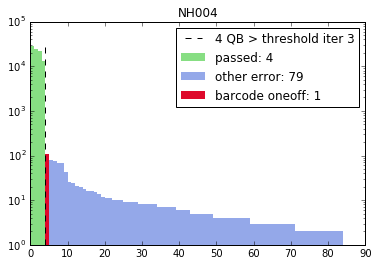

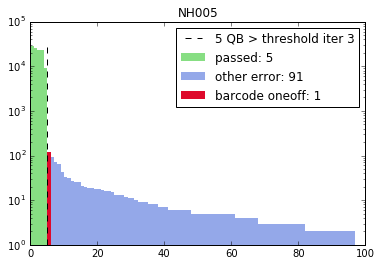

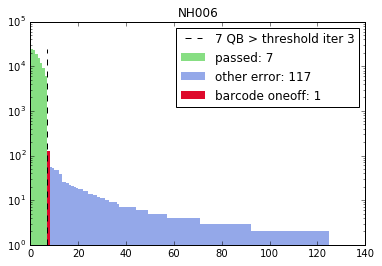

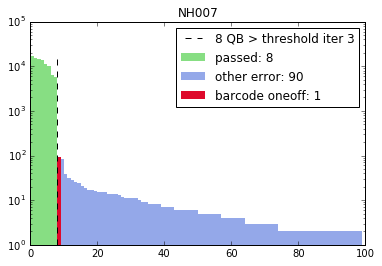

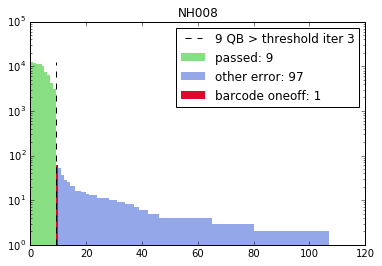

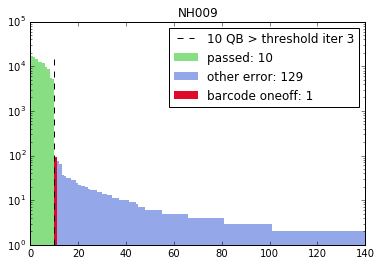

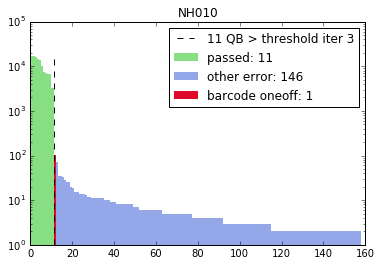

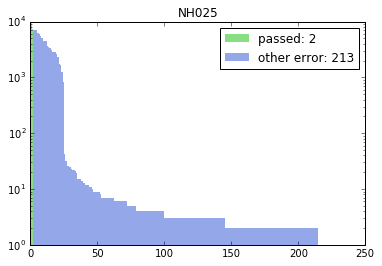

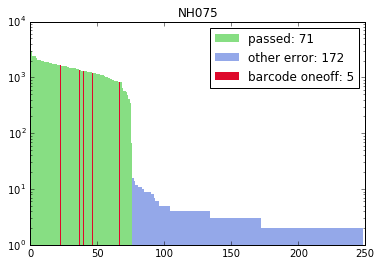

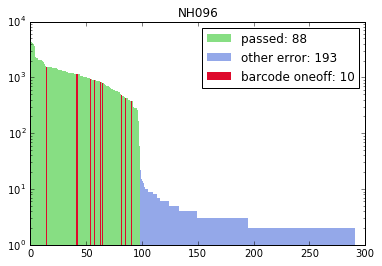

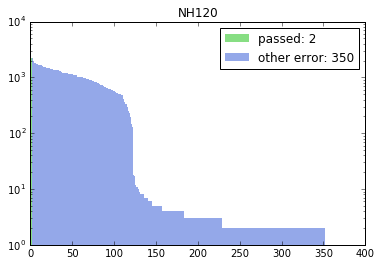

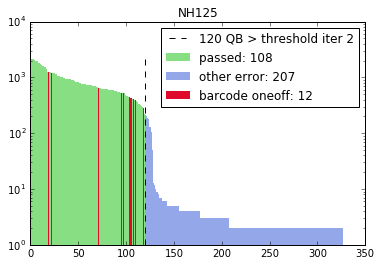

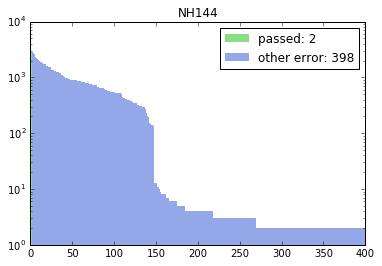

In [25]:
# plots scatter
plottype = 'bar'
mcounts=MCOUNTS
counter = 0
for idx, group in merged.groupby('idx'):
#     if idx[:2]=='NH':
    if idx in all_threshold_logs:
        gslice = group.sort_values(by=mcounts,ascending=False)
        gslice = gslice.loc[gslice[mcounts]>1]
        counts = gslice[mcounts].values
        itypes = gslice.itype.values
        it_present= np.unique(itypes)
        
        f, ax = plt.subplots(1)
        for itype in itype_order:
            if itype in it_present:
                x = np.where(itypes==itype)[0]
                y = counts[x]
                label = "%s: %d"%(itype,len(x))
                color = ctypes[itype]
                alpha = 0.5 if itype in ['passed','other error'] else 1
                edgecolor=color
                lw = 1.5
                s = 250 if itype in ['barcode oneoff','qtag mismatch'] else 8
                marker = "|" if itype in ['barcode oneoff','qtag mismatch'] else "o"
                    
                if plottype == 'scatter':
                    ax.scatter(x+1, y, color=color, edgecolors=edgecolor,
                            alpha=alpha, label=label, 
                            marker=marker, lw=lw, s=s)
                    
                else:
                    ax.bar(x, y, color=color, alpha=alpha, 
                           label=label, lw=0, width=1 )
        
        thresh_values = all_threshold_logs[idx]
        thresh_line_fmts = 1
        for tline in range(1,len(thresh_values)):
            thresh_line = thresh_values[tline]
    #             thresh_line =np.max(np.where(itypes=='passed')[0])+1

            if thresh_line != thresh_values[tline-1]:
#                 alpha = thresh_line_fmts[len(thresh_values)-tline-1]
                alpha = thresh_line_fmts - 0.5*(tline-1)
                ax.plot([thresh_line,thresh_line],[1,max(counts)], 
                        color = 'black', alpha = 1, ls = '--',
                        label='%d QB > threshold iter %d'%(thresh_line, tline+1))
        ax.set_yscale('log')
        ax.set_xlim(0)
        ax.legend()
        ax.set_title(idx)
#         break


    